<a href="https://www.kaggle.com/code/amryasser215/speech-emotion-recognition?scriptVersionId=131031785" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Names
### 6772 - Amr Yasser
### 7020 - Marwan Khaled
### 6716 - Elhussien Sabri

# Citation - 1
Network Architecture: Issa, D., Fatih Demirci, M., & Yazici, A. (2020). Speech emotion recognition with deep convolutional neural networks. Biomedical Signal Processing and Control, 59, 101894. https://doi.org/10.1016/j.bspc.2020.101894

# Citation - 2
Zielonka, M.; Piastowski, A.; Czyzewski, A.; Nadachowski, P.; Operlejn, M.; Kaczor, K. "Recognition of Emotions in Speech Using Convolutional Neural Networks on Different Datasets." Electronics 2022, 11, 3831. [Online]. Available: https://doi.org/10.3390/electronics11223831. Academic Editors: Daniel Hládek, Matúš Pleva, Piotr Szczuko, and Andrej Zgank. Received: 9 August 2022. Accepted: 15 November 2022. Published: 21 November 2022. Publisher’s Note: MDPI stays neutral with regard to jurisdictional claims in published maps and institutional affiliations.

# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from keras.models import load_model
from skimage.transform import resize


# Utils

In [2]:
def load_data(path):
    data_dir = Path(path)

    filepaths = pd.Series( list(data_dir.glob(r'**/*.wav')), name='file_path').astype(str)
    labels = pd.Series(list(map(lambda x: os.path.split(x)[1].split('_')[2], filepaths)), name='label')

    df = pd.concat([filepaths, labels], axis=1)
    return df

In [4]:
def show_samples(df):
    # Shuffle the DataFrame
    shuffled_df = df.sample(frac=1).reset_index(drop=True)

    # Iterate over unique labels in the shuffled DataFrame
    for label in shuffled_df['label'].unique():
        # Filter DataFrame for the current label
        label_df = shuffled_df[shuffled_df['label'] == label].head(1)  # Take the first example for each label

        # Extract file path and label
        file_path = label_df['file_path'].values[0]
        label = label_df['label'].values[0]

        # Load audio file using librosa
        audio, sr = librosa.load(file_path)

        # Generate the time axis for the waveform
        duration = len(audio) / sr
        time = librosa.times_like(audio, sr=sr)

        # Plot waveform
        plt.plot(time, audio)
        plt.title(f'Waveform for {label}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.show()
        print()
        
        # Play the audio
        ipd.display(ipd.Audio(audio, rate=sr))
        print()
        print()

In [9]:
def scale(train,test,val):
    # Create an instance of MinMaxScaler
    scaler = MinMaxScaler()

    # Select the columns to be scaled (excluding the 'label' column)
    columns_to_scale = train.columns.drop('label')
    
    scaler.fit(train[columns_to_scale])
    
    # Scale the selected columns
    train[columns_to_scale] = scaler.transform(train[columns_to_scale])
    test[columns_to_scale] = scaler.transform(test[columns_to_scale])
    val[columns_to_scale] = scaler.transform(val[columns_to_scale])
    
    return train, test, val

In [2]:
def extract_most_confusing_classes(confusion_matrix):
    # Compute misclassification rate for each class
    misclassification_rates = np.zeros(confusion_matrix.shape[0])
    for i in range(confusion_matrix.shape[0]):
        total_samples = np.sum(confusion_matrix[i, :])
        misclassified_samples = total_samples - confusion_matrix[i, i]
        misclassification_rates[i] = misclassified_samples / total_samples
    
    # Sort classes based on misclassification rates in descending order
    sorted_indices = np.argsort(misclassification_rates)[::-1]
    
    # Sort misclassification rates in descending order
    sorted_rates = misclassification_rates[sorted_indices]
    
    return sorted_indices, sorted_rates

def evaluate(model, X_test, y_test, label_encoder):
    # Predict probabilities for the test set
    y_pred_prob = model.predict(X_test)
    
    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    y_test = np.argmax(y_test, axis=1)
    
    # Get class names
    class_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))
    
    # Mapping dictionary
    mapping = {
        'SAD': 'sadness',
        'ANG': 'angry',
        'DIS': 'disgust',
        'FEA': 'fear',
        'HAP': 'happy',
        'NEU': 'neutral'
    }

    # Replace values using the mapping dictionary
    class_names = np.array([mapping[val] for val in class_names])
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print()
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',cbar=True, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Compute test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print('\nTest Accuracy: {:.4f}%'.format(test_accuracy*100))
    
    # Compute F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('F1-score: {:.4f}'.format(f1))
    
    # Print classification report
    report = classification_report(y_test, y_pred, target_names=class_names)
    print('\nClassification Report:\n', report)
    
    # Extract the most confusing classes
    most_confusing_classes = extract_most_confusing_classes(cm)
    
    print('\nMost confusing classes (class - rate):\n')
    # Extract the most confusing classes and their rates
    most_confusing_classes, confusion_rates = extract_most_confusing_classes(cm)

    # Print the most confusing classes and their rates
    i = 1
    for cls, rate in zip(most_confusing_classes, confusion_rates):
        print(f'{i}- {class_names[cls]} - {rate}')
        i = i + 1

In [3]:
def save():
    dic = { 
            'fspc_1_train':fspc_1_train,
            'fspc_1_test':fspc_1_test,
            'fspc_1_val':fspc_1_val,
            'fspc_2_train':fspc_2_train,
            'fspc_2_trainlb':fspc_2_trainlb,
            'fspc_2_test':fspc_2_test,
            'fspc_2_testlb':fspc_2_testlb,
            'fspc_2_val':fspc_2_val,
            'fspc_2_vallb':fspc_2_vallb,

    }
    
    torch.save(dic,'data.pth')
    
def load(data):
    data = torch.load(f'/kaggle/input/speech-emotion-recognition/{data}.pth') 
    return data

In [4]:
load_flag=True

### Init/Reset

In [10]:
load_flag=False

# Dataset

### Kaggle

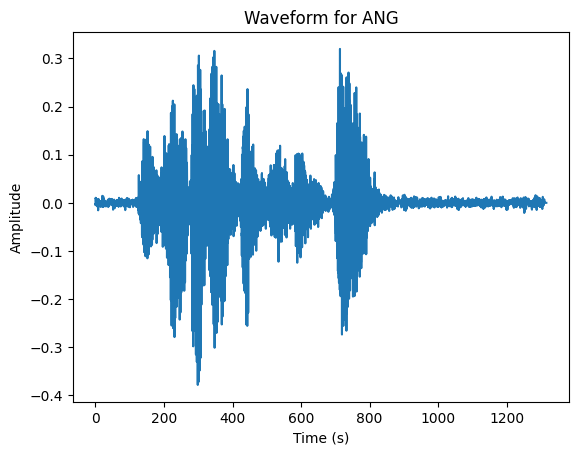

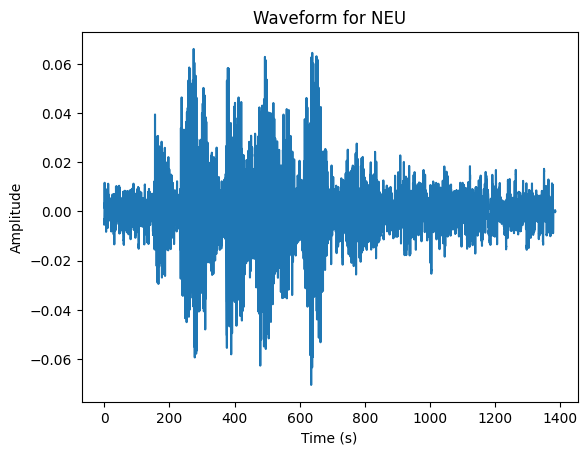

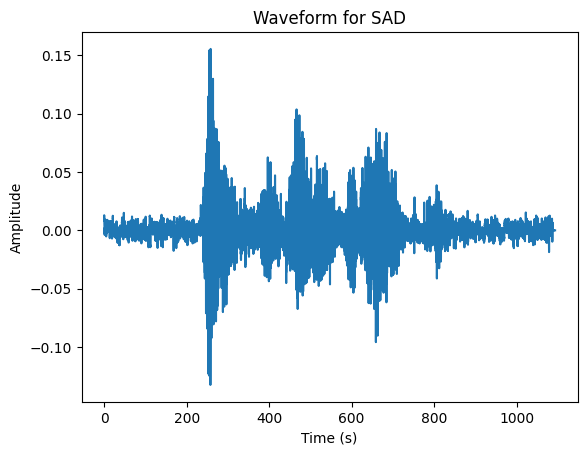

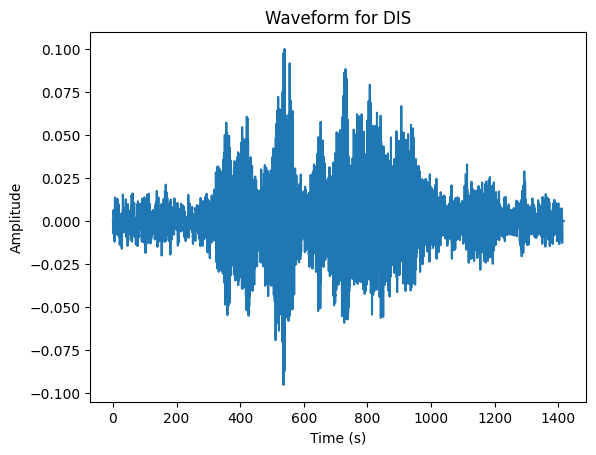

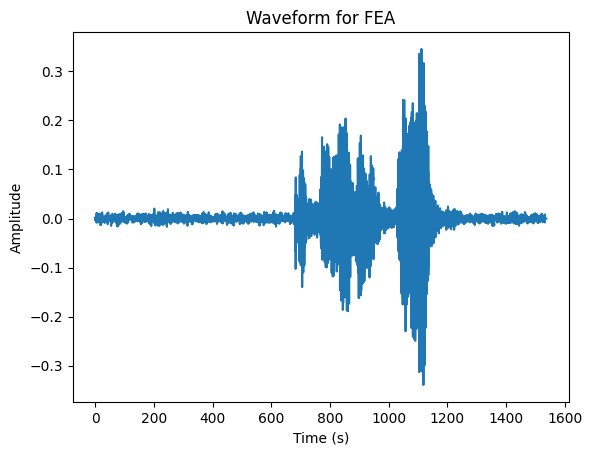

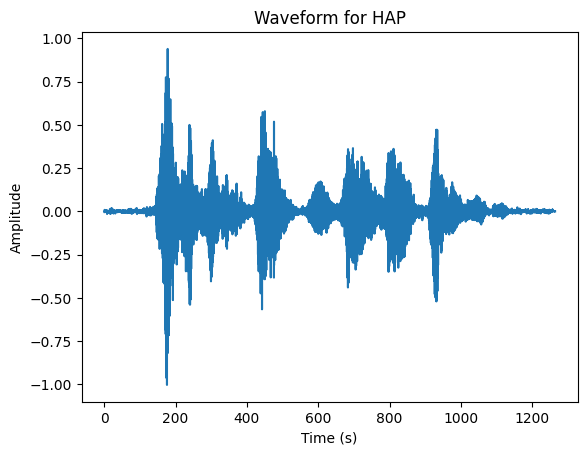

,file_path,label
0,../input/speech-emotion-recognition-en/Crema/1...,DIS
1,../input/speech-emotion-recognition-en/Crema/1...,HAP
2,../input/speech-emotion-recognition-en/Crema/1...,HAP
3,../input/speech-emotion-recognition-en/Crema/1...,DIS
4,../input/speech-emotion-recognition-en/Crema/1...,DIS
...,...,...
7437,../input/speech-emotion-recognition-en/Crema/1...,ANG
7438,../input/speech-emotion-recognition-en/Crema/1...,ANG
7439,../input/speech-emotion-recognition-en/Crema/1...,ANG
7440,../input/speech-emotion-recognition-en/Crema/1...,SAD


In [9]:
crema_df = load_data('../input/speech-emotion-recognition-en/Crema')

show_samples(crema_df)
crema_df

# Data Split

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(crema_df['file_path'], crema_df['label'], test_size=0.3, random_state=42,stratify=crema_df['label'])
    
trainval = pd.concat([X_trainval,y_trainval], axis = 1)
test = pd.concat([X_test,y_test],axis = 1)

    
print('Train and Validation Data')
print(trainval.info(verbose=True))
print(trainval['label'].value_counts())
print('\nTest Data')
print(test.info(verbose=True))
print(test['label'].value_counts())


# Feature Extraction and Augmentation

### Augmentation

In [12]:
def noise(data,sr):
    rate=0.035
    threshold=0.075
    
    noise=rate*np.random.uniform()*np.amax(data)
    augmented_data=data+noise*np.random.normal(size=data.shape[0])
    return augmented_data

def pitching(data,sr):
    pitch_factor=0.7
    return librosa.effects.pitch_shift(data,sr=sr,n_steps=pitch_factor)


def stretch(data,sr):
    rate=0.8
    return librosa.effects.time_stretch(data, rate=rate)


def shift(data,sr):
    rate=1000
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

In [13]:
def augment(df,aug=None,aug2=None):
    aug_list = []
    sr_list = []
    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        # Load the wave file
        audio_path = row['file_path']
        audio, sr = librosa.load(audio_path, sr = 22050)
        
        if len(audio) > (3*22050):
            audio = audio[:3*22050]
        else:
            padding = (3*22050) - len(audio)
#             offset = padding // 2
            audio = np.pad(audio, (0, padding), mode='constant')

        
        if aug:
            if aug2:
                audio = aug2(audio,sr)
            aug_list.append(aug(audio,sr))
        else:
            aug_list.append(audio)
        
        sr_list.append(sr)
     # Create a dictionary from the lists
    data_dict = {
        'data': aug_list,
        'sr':  sr_list,
        'label': df['label']
    }
    
    return pd.DataFrame(data_dict)

### Different Augmentations

In [14]:
test_data = augment(test).reset_index(drop=True)
test_data

,data,sr,label
0,"[0.0070274556, 0.0074722953, 0.006453802, 0.00...",22050,SAD
1,"[0.0056585, 0.0067260466, 0.0055813645, 0.0056...",22050,SAD
2,"[-0.0065092617, -0.007462355, -0.0060850307, -...",22050,ANG
3,"[-0.0013599849, -0.00056917605, 0.00027667056,...",22050,FEA
4,"[0.0016922303, 0.0020052395, 0.0017440937, 0.0...",22050,FEA
...,...,...,...
2228,"[0.0039783902, 0.0052618356, 0.0045635346, 0.0...",22050,HAP
2229,"[0.0019951407, 0.002379264, 0.0019273763, 0.00...",22050,HAP
2230,"[-0.0003583942, 0.00038323097, 0.0016104317, 0...",22050,NEU
2231,"[-0.001667049, -0.0023690686, -0.002691716, -0...",22050,ANG


In [15]:
X_train, X_val, y_train, y_val = train_test_split(trainval.drop('label', axis=1), trainval['label'], test_size=0.05, random_state=42,stratify=trainval['label'])

train = pd.concat([X_train,y_train], axis = 1)
val = pd.concat([X_val,y_val],axis = 1)

In [ ]:
trainval_data = augment(trainval).reset_index(drop=True)
trainval_data

In [16]:
train_data = pd.concat([augment(train),augment(train,noise),augment(train,pitching),augment(train,shift)],axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
train_data

,data,sr,label
0,"[-0.0048280237, -0.00595121, -0.0059444923, -0...",22050,SAD
1,"[0.0073943, 0.007522534, 0.008443896, 0.008597...",22050,NEU
2,"[-0.0037886475571089276, -0.000348400499592295...",22050,HAP
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,DIS
4,"[0.0060920008, 0.007774321, 0.0062305033, 0.00...",22050,HAP
...,...,...,...
19787,"[-0.0042852433, -0.005040763, -0.0047730426, -...",22050,SAD
19788,"[-0.0017260718, -0.0019799408, -0.0019164354, ...",22050,SAD
19789,"[0.00876284141898392, 0.0078726965700999, 0.00...",22050,DIS
19790,"[0.0008986454, 0.0009675302, 0.0007370438, 0.0...",22050,DIS


In [17]:
val_data = augment(val).reset_index(drop=True)
val_data

,data,sr,label
0,"[0.00017823323, 0.0012775706, 0.0021629964, 0....",22050,SAD
1,"[-0.0030892524, -0.003287116, -0.0026380788, -...",22050,ANG
2,"[-0.0015305243, -0.0011047729, -7.203821e-05, ...",22050,DIS
3,"[-0.004386563, -0.004436136, -0.003394309, -0....",22050,SAD
4,"[0.002350495, 0.002623403, 0.0018401169, 0.001...",22050,HAP
...,...,...,...
256,"[-0.009561619, -0.010532294, -0.009671453, -0....",22050,DIS
257,"[-0.0031609894, -0.0032626067, -0.0026585765, ...",22050,ANG
258,"[0.0050352495, 0.006635066, 0.0058214334, 0.00...",22050,NEU
259,"[-0.0013701881, -0.00039190368, -3.3039774e-05...",22050,SAD


### Features

In [18]:
# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T)

In [19]:
def extract_features(df,atype= 1):
    # Create empty lists to store the extracted features
    zero_crossing_rate_list = []
    energy_list = []
    rmse_list = []
    mfcc_list = []
    chroma_list = []
    centroid_list = []
    contrast_list = []
    label_list = []
    
    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        audio = row['data']
        sr = row['sr']
        
        # Calculate the zero crossing rate
        zero_crossing_rate_list.append(zcr(audio).tolist())

        # Calculate the energy
        energy_list.append(energy(audio).tolist())
        
        # Calculate the rms
        rmse_list.append(rmse(audio).tolist())
       
        # Calculate the mfcc
        mfcc_list.append(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13).flatten())
        
#         # Calculate the chroma
#         chroma_list.append(librosa.feature.chroma_stft(y=audio, sr=sr).flatten())
        
#         # Calculate the centroid
#         centroid_list.append(librosa.feature.spectral_centroid(y=audio, sr=sr).flatten())
        
#         # Calculate the contrast
#         contrast_list.append(librosa.feature.spectral_centroid(y=audio, sr=sr).flatten())
        
        # Save the label
        label_list.append(row['label'])
 
    # Create a dictionary from the lists
    features_dict = {
        'zero_crossing_rate': zero_crossing_rate_list,
        'energy': energy_list,
        'rmse': rmse_list,
        'mfcc': mfcc_list,
#         'chroma': chroma_list,
#         'contrast': contrast_list,
#         'centroid': centroid_list,
        'label': label_list
    }
    
    return pd.DataFrame(features_dict)

def extract_spectro(audio,sr):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram.T  # Transpose the spectrogram

In [20]:
def unpack(df):
    return pd.concat([df.drop(['zero_crossing_rate','energy','rmse','mfcc'], axis=1),
                            df['zero_crossing_rate'].apply(pd.Series).add_prefix('zcr_'),
                            df['energy'].apply(pd.Series).add_prefix('energy_'),
                            df['rmse'].apply(pd.Series).add_prefix('rms_'),
                            df['mfcc'].apply(pd.Series).add_prefix('mfcc_'),
#                             df['chroma'].apply(pd.Series).add_prefix('chroma_'),
#                             df['contrast'].apply(pd.Series).add_prefix('contrast_'),
#                             df['centroid'].apply(pd.Series).add_prefix('centroid_')
                     ], axis=1)

In [21]:
def prepare_spectrograms(spectrograms):
    if not isinstance(spectrograms, (list, np.ndarray)):
        raise ValueError("spectrograms must be a list or ndarray")

    processed_spectrograms = []
    for spec in spectrograms:
        if not isinstance(spec, np.ndarray):
            raise ValueError("Each spectrogram must be a numpy array")

        if spec.dtype != np.float32:
            spec = spec.astype(np.float32)

        max_height = spec.shape[0]
        max_width = spec.shape[1]

        resized_spec = resize(spec, (max_height, max_width), mode='constant')

        normalized_spec = (resized_spec - np.mean(resized_spec)) / np.std(resized_spec)
        normalized_spec = np.nan_to_num(normalized_spec)
        
        processed_spectrograms.append(normalized_spec)

    stacked_spectrograms = np.stack(processed_spectrograms, axis=0)
    stacked_spectrograms = stacked_spectrograms[..., np.newaxis]

    return stacked_spectrograms


### Generic

In [22]:
def get_features(df, threshold = 0.95,mode = 1):
    if mode == 1:
        df = extract_features(df)
        # Explode the features arrays
        df = unpack(df)

        # Handle NaNs
        print('NaNs in feature space before being removed')
        print(df.isna().sum())

        # Drop features with more than 60% NaNs
        df = df.dropna(thresh=threshold  * len(df), axis=1)

#         # Replacing NaNs with mean of the feature wrt label
#         # Iterate over each column in the DataFrame
#         for column in df.columns:
#             # Check if the column has NaN values
#             if df[column].isna().any():
#                 # Group the DataFrame by the 'label' column and calculate the mean for each group
#                 means = df.groupby('label')[column].transform('mean')
#                 # Replace the NaN values in the column with the corresponding means
#                 df.loc[df[column].isna(), column] = means

        return df.sample(frac=1, random_state=42).reset_index(drop=True)   
    
    if mode == 2:
        mel_spectrograms = []
        
        for index, row in df.iterrows():
            audio = row['data']
            sr = row['sr']
            
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
            mel_spectrogram = mel_spectrogram.T  # Transpose the spectrogram
            mel_spectrograms.append(mel_spectrogram)
            

        mel_spectrograms = np.array(mel_spectrograms,dtype='object')
        
        return prepare_spectrograms(mel_spectrograms)

## Feature Space 1

In [5]:
if not load_flag:
    fspc_1_train = get_features(train_data)
else:
    print('Data has been processed, scaled version:\n')
    fspc_1_train = load('fspc_1_train')

fspc_1_train

Data has been processed, scaled version:



,label,zcr_0,zcr_1,zcr_2,zcr_3,zcr_4,zcr_5,zcr_6,zcr_7,zcr_8,...,mfcc_1680,mfcc_1681,mfcc_1682,mfcc_1683,mfcc_1684,mfcc_1685,mfcc_1686,mfcc_1687,mfcc_1688,mfcc_1689
0,NEU,0.075540,0.069658,0.073620,0.080000,0.085661,0.087488,0.095373,0.109346,0.096925,...,0.468267,0.479990,0.377235,0.291887,0.322708,0.429033,0.334792,0.349712,0.411885,0.445117
1,FEA,0.057554,0.066116,0.073620,0.080930,0.081937,0.077140,0.059490,0.074766,0.070829,...,0.652543,0.735977,0.704422,0.706126,0.651989,0.631894,0.448926,0.436963,0.465776,0.505812
2,HAP,0.066547,0.064935,0.067485,0.076279,0.073557,0.067733,0.065156,0.063551,0.054986,...,0.432142,0.419814,0.317223,0.359375,0.436815,0.571943,0.400409,0.378317,0.294387,0.387751
3,NEU,0.073741,0.099174,0.086766,0.108837,0.101490,0.078081,0.082153,0.065421,0.068966,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
4,HAP,0.039568,0.041322,0.045574,0.058605,0.059590,0.060207,0.062323,0.075701,0.068966,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19787,DIS,0.043165,0.041322,0.040316,0.041860,0.066108,0.085607,0.098206,0.101869,0.080149,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
19788,NEU,0.098921,0.116883,0.108677,0.121860,0.105214,0.118532,0.172805,0.220561,0.247903,...,0.504773,0.399426,0.207737,0.282348,0.266389,0.288329,0.305378,0.335122,0.312031,0.373206
19789,DIS,0.654676,0.643447,0.651183,0.743256,0.724395,0.774224,0.748820,0.741121,0.732526,...,0.479537,0.450178,0.390022,0.448594,0.538252,0.474469,0.373641,0.455209,0.433144,0.493936
19790,FEA,0.057554,0.059032,0.066608,0.065116,0.058659,0.053622,0.047214,0.050467,0.065238,...,0.469084,0.498157,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595


In [6]:
if not load_flag:
    fspc_1_test = get_features(test_data)
else:
    print('Data has been processed, scaled version:\n')
    fspc_1_test = load('fspc_1_test')

fspc_1_test

Data has been processed, scaled version:



,label,zcr_0,zcr_1,zcr_2,zcr_3,zcr_4,zcr_5,zcr_6,zcr_7,zcr_8,...,mfcc_1680,mfcc_1681,mfcc_1682,mfcc_1683,mfcc_1684,mfcc_1685,mfcc_1686,mfcc_1687,mfcc_1688,mfcc_1689
0,ANG,0.043165,0.048406,0.052585,0.063256,0.066108,0.067733,0.065156,0.059813,0.055918,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
1,FEA,0.044964,0.050767,0.061350,0.078140,0.083799,0.092192,0.088763,0.078505,0.076421,...,0.783463,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
2,NEU,0.048561,0.053129,0.049956,0.051163,0.054004,0.063970,0.070822,0.066355,0.063374,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
3,SAD,0.052158,0.059032,0.063103,0.071628,0.079143,0.083725,0.078376,0.082243,0.072693,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
4,FEA,0.070144,0.061393,0.061350,0.060465,0.058659,0.072437,0.070822,0.069159,0.068034,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2228,ANG,0.073741,0.062574,0.071867,0.069767,0.080074,0.104421,0.101983,0.110280,0.093197,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
2229,SAD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000932,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
2230,NEU,0.070144,0.061393,0.060473,0.062326,0.054004,0.051740,0.048159,0.044860,0.045666,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
2231,HAP,0.039568,0.043684,0.048203,0.053023,0.059590,0.088429,0.131256,0.143925,0.149115,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595


In [7]:
if not load_flag:
    fspc_1_val = get_features(val_data)
else:
    print('Data has been processed, scaled version:\n')
    fspc_1_val = load('fspc_1_val')

fspc_1_val

Data has been processed, scaled version:



,label,zcr_0,zcr_1,zcr_2,zcr_3,zcr_4,zcr_5,zcr_6,zcr_7,zcr_8,...,mfcc_1680,mfcc_1681,mfcc_1682,mfcc_1683,mfcc_1684,mfcc_1685,mfcc_1686,mfcc_1687,mfcc_1688,mfcc_1689
0,SAD,0.071942,0.060213,0.050833,0.051163,0.046555,0.045155,0.062323,0.067290,0.065238,...,0.504773,0.492986,0.42440,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
1,NEU,0.044964,0.047226,0.044698,0.047442,0.048417,0.058325,0.053824,0.050467,0.052190,...,0.504773,0.492986,0.42440,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
2,SAD,0.059353,0.051948,0.049080,0.053953,0.049348,0.052681,0.051936,0.053271,0.054054,...,0.504773,0.492986,0.42440,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
3,ANG,0.028777,0.049587,0.056968,0.059535,0.068901,0.053622,0.051936,0.046729,0.042870,...,0.504773,0.492986,0.42440,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
4,SAD,0.073741,0.068477,0.065732,0.055814,0.061453,0.059266,0.060434,0.071028,0.060578,...,0.504773,0.492986,0.42440,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,SAD,0.050360,0.051948,0.059597,0.068837,0.085661,0.090310,0.078376,0.074766,0.062442,...,0.560668,0.592297,0.56846,0.578278,0.539182,0.446228,0.414779,0.408336,0.541679,0.617978
257,DIS,0.086331,0.082645,0.072743,0.074419,0.055866,0.054563,0.067989,0.074766,0.084809,...,0.504773,0.492986,0.42440,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
258,NEU,0.028777,0.038961,0.035057,0.043721,0.051210,0.046096,0.053824,0.051402,0.059646,...,0.504773,0.492986,0.42440,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
259,HAP,0.046763,0.049587,0.058720,0.058605,0.057728,0.056444,0.052880,0.067290,0.072693,...,0.504773,0.492986,0.42440,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(fspc_1_trainval.drop('label', axis=1), fspc_1_trainval['label'], test_size=0.05, random_state=42,stratify=fspc_1_trainval['label'])

fspc_1_train = pd.concat([X_train,y_train], axis = 1)
fspc_1_train

In [ ]:
fspc_1_val = pd.concat([X_val,y_val], axis = 1)
fspc_1_val

### Scale the features

In [26]:
fspc_1_train,fspc_1_test, fspc_1_val = scale(fspc_1_train,fspc_1_test,fspc_1_val)

fspc_1_train

,label,zcr_0,zcr_1,zcr_2,zcr_3,zcr_4,zcr_5,zcr_6,zcr_7,zcr_8,...,mfcc_1680,mfcc_1681,mfcc_1682,mfcc_1683,mfcc_1684,mfcc_1685,mfcc_1686,mfcc_1687,mfcc_1688,mfcc_1689
0,NEU,0.075540,0.069658,0.073620,0.080000,0.085661,0.087488,0.095373,0.109346,0.096925,...,0.468267,0.479990,0.377235,0.291887,0.322708,0.429033,0.334792,0.349712,0.411885,0.445117
1,FEA,0.057554,0.066116,0.073620,0.080930,0.081937,0.077140,0.059490,0.074766,0.070829,...,0.652543,0.735977,0.704422,0.706126,0.651989,0.631894,0.448926,0.436963,0.465776,0.505812
2,HAP,0.066547,0.064935,0.067485,0.076279,0.073557,0.067733,0.065156,0.063551,0.054986,...,0.432142,0.419814,0.317223,0.359375,0.436815,0.571943,0.400409,0.378317,0.294387,0.387751
3,NEU,0.073741,0.099174,0.086766,0.108837,0.101490,0.078081,0.082153,0.065421,0.068966,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
4,HAP,0.039568,0.041322,0.045574,0.058605,0.059590,0.060207,0.062323,0.075701,0.068966,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19787,DIS,0.043165,0.041322,0.040316,0.041860,0.066108,0.085607,0.098206,0.101869,0.080149,...,0.504773,0.492986,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595
19788,NEU,0.098921,0.116883,0.108677,0.121860,0.105214,0.118532,0.172805,0.220561,0.247903,...,0.504773,0.399426,0.207737,0.282348,0.266389,0.288329,0.305378,0.335122,0.312031,0.373206
19789,DIS,0.654676,0.643447,0.651183,0.743256,0.724395,0.774224,0.748820,0.741121,0.732526,...,0.479537,0.450178,0.390022,0.448594,0.538252,0.474469,0.373641,0.455209,0.433144,0.493936
19790,FEA,0.057554,0.059032,0.066608,0.065116,0.058659,0.053622,0.047214,0.050467,0.065238,...,0.469084,0.498157,0.424400,0.458328,0.459094,0.480134,0.407742,0.425005,0.420946,0.471595


In [ ]:
save()

## Feature Space 2

In [5]:
if not load_flag:
    fspc_2_train = get_features(train_data, mode=2)
    fspc_2_trainlb = train_data.reset_index(drop=True)['label']

else:
    print('Data has been processed, scaled version:\n')
    fspc_2_train = load('fspc_2_train')
    fspc_2_trainlb = load('fspc_2_trainlb')

print(fspc_2_train.shape)
fspc_2_tr_df = pd.DataFrame(fspc_2_train.reshape(fspc_2_train.shape[0], -1))
fspc_2_tr_df['label'] = fspc_2_trainlb


fspc_2_tr_df[:20]

Data has been processed, scaled version:

(19792, 130, 128, 1)


,0,1,2,3,4,5,6,7,8,9,...,16631,16632,16633,16634,16635,16636,16637,16638,16639,label
0,1.627099,1.473755,1.231636,1.144964,1.330578,1.445538,1.392320,1.642987,1.604459,1.329975,...,-1.350900,-1.350900,-1.350900,-1.350900,-1.350900,-1.350900,-1.350900,-1.350900,-1.350900,SAD
1,1.918461,1.510921,1.447613,1.266609,1.275631,1.247903,1.228090,1.946482,2.173563,1.711825,...,-0.943160,-0.943160,-0.943160,-0.943160,-0.943160,-0.943160,-0.943160,-0.943160,-0.943160,NEU
2,1.419624,0.915526,1.262634,1.520829,0.744305,0.716190,1.166754,1.477528,1.453391,0.555692,...,-0.859746,-0.847378,-0.793320,-0.462703,-0.539478,-0.347286,-0.849156,-0.909666,-0.782568,HAP
3,-0.903485,-0.903485,-0.903485,-0.903485,-0.903485,-0.903485,-0.903485,-0.903485,-0.903485,-0.903485,...,-0.903485,-0.903485,-0.903485,-0.903485,-0.903485,-0.903485,-0.903485,-0.903485,-0.903485,DIS
4,1.414563,1.194872,1.272945,1.318513,1.127486,1.243458,1.311224,1.211301,0.871459,0.834647,...,-1.210042,-1.210042,-1.210042,-1.210042,-1.210042,-1.210042,-1.210042,-1.210042,-1.210042,HAP
5,0.722331,0.210747,0.299721,0.629539,0.801337,0.517690,0.978887,1.060587,0.644710,0.698277,...,-1.232651,-1.232651,-1.232651,-1.232651,-1.232651,-1.232651,-1.232651,-1.232651,-1.232651,ANG
6,1.758898,1.724838,1.617985,1.472687,1.569613,1.690959,1.488601,1.400966,1.712262,1.835973,...,-0.899902,-0.899902,-0.899902,-0.899902,-0.899902,-0.899902,-0.899902,-0.899902,-0.899902,DIS
7,0.991204,1.454373,1.485221,1.079973,0.954413,1.238537,1.593525,1.733001,1.539886,1.137468,...,-1.846057,-1.846057,-1.846057,-1.846057,-1.846057,-1.846057,-1.846057,-1.846057,-1.846057,HAP
8,1.203013,1.200196,1.389554,1.561122,1.280973,1.473072,1.775878,1.468487,0.904157,0.939832,...,-1.024833,-0.837485,-0.989365,-0.731089,-0.776016,-1.039654,-1.066112,-0.864126,-1.059119,NEU
9,2.211635,2.322943,2.593997,2.704174,2.177185,2.001693,2.828934,3.123983,2.867836,1.946952,...,-0.978788,-0.854755,-0.967203,-0.791411,-0.878108,-0.859083,-0.881022,-0.998663,-1.140212,SAD


In [6]:
if not load_flag:
    fspc_2_test = get_features(test_data, mode=2)
    fspc_2_testlb = test_data.reset_index(drop=True)['label']

else:
    print('Data has been processed, scaled version:\n')
    fspc_2_test = load('fspc_2_test')
    fspc_2_testlb = load('fspc_2_testlb')

print(fspc_2_test.shape)
fspc_2_ts_df = pd.DataFrame(fspc_2_test.reshape(fspc_2_test.shape[0], -1))
fspc_2_ts_df['label'] = fspc_2_testlb


fspc_2_ts_df[:20]

Data has been processed, scaled version:

(2233, 130, 128, 1)


,0,1,2,3,4,5,6,7,8,9,...,16631,16632,16633,16634,16635,16636,16637,16638,16639,label
0,1.168720,1.318070,1.421090,1.543890,1.257529,0.991767,1.205207,1.531068,1.631971,1.484531,...,-1.542673,-1.542673,-1.542673,-1.542673,-1.542673,-1.542673,-1.542673,-1.542673,-1.542673,SAD
1,1.609266,1.587309,1.554308,1.252163,1.478660,1.557083,1.726636,1.962178,1.886614,1.619390,...,-1.498127,-1.498127,-1.498127,-1.498127,-1.498127,-1.498127,-1.498127,-1.498127,-1.498127,SAD
2,0.299230,0.506310,0.347607,0.146296,0.192544,0.543003,0.651521,0.828467,0.541841,0.419462,...,-1.136436,-1.136436,-1.136436,-1.136436,-1.136436,-1.136436,-1.136436,-1.136436,-1.136436,ANG
3,1.190865,1.256717,1.329291,1.592449,1.570760,1.371687,1.174215,1.400593,1.196026,1.311053,...,-1.246705,-1.246705,-1.246705,-1.246705,-1.246705,-1.246705,-1.246705,-1.246705,-1.246705,FEA
4,1.439731,1.161919,1.285703,1.439177,1.354339,0.966277,1.243123,1.628564,1.519758,1.426206,...,-1.186956,-1.186956,-1.186956,-1.186956,-1.186956,-1.186956,-1.186956,-1.186956,-1.186956,FEA
5,0.931000,1.318786,1.422179,1.095976,1.444793,1.263382,1.665087,1.643435,1.467595,1.246260,...,-1.781068,-1.781068,-1.781068,-1.781068,-1.781068,-1.781068,-1.781068,-1.781068,-1.781068,HAP
6,0.277429,0.336635,0.514010,0.668764,0.650241,0.654282,0.757403,0.589246,0.126129,0.187823,...,-0.969559,-0.969559,-0.969559,-0.969559,-0.969559,-0.969559,-0.969559,-0.969559,-0.969559,ANG
7,-0.068885,0.073989,0.145241,0.322462,0.149468,0.524726,0.483192,0.484418,0.430078,0.097906,...,-1.215090,-1.215090,-1.215090,-1.215090,-1.215090,-1.215090,-1.215090,-1.215090,-1.215090,ANG
8,1.049239,1.123086,1.103000,0.813981,1.149525,1.163872,0.752641,1.288152,1.399333,0.897448,...,-1.053942,-1.053942,-1.053942,-1.053942,-1.053942,-1.053942,-1.053942,-1.053942,-1.053942,HAP
9,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,-1.050573,-0.889964,-0.774920,-0.735804,...,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,ANG


In [7]:
if not load_flag:
    fspc_2_val = get_features(val_data, mode=2)
    fspc_2_vallb = val_data.reset_index(drop=True)['label']

else:
    print('Data has been processed, scaled version:\n')
    fspc_2_val = load('fspc_2_val')
    fspc_2_vallb = load('fspc_2_vallb')

print(fspc_2_test.shape)
fspc_2_vl_df = pd.DataFrame(fspc_2_test.reshape(fspc_2_test.shape[0], -1))
fspc_2_vl_df['label'] = fspc_2_vallb


fspc_2_vl_df[:20]

Data has been processed, scaled version:

(2233, 130, 128, 1)


,0,1,2,3,4,5,6,7,8,9,...,16631,16632,16633,16634,16635,16636,16637,16638,16639,label
0,1.168720,1.318070,1.421090,1.543890,1.257529,0.991767,1.205207,1.531068,1.631971,1.484531,...,-1.542673,-1.542673,-1.542673,-1.542673,-1.542673,-1.542673,-1.542673,-1.542673,-1.542673,SAD
1,1.609266,1.587309,1.554308,1.252163,1.478660,1.557083,1.726636,1.962178,1.886614,1.619390,...,-1.498127,-1.498127,-1.498127,-1.498127,-1.498127,-1.498127,-1.498127,-1.498127,-1.498127,ANG
2,0.299230,0.506310,0.347607,0.146296,0.192544,0.543003,0.651521,0.828467,0.541841,0.419462,...,-1.136436,-1.136436,-1.136436,-1.136436,-1.136436,-1.136436,-1.136436,-1.136436,-1.136436,DIS
3,1.190865,1.256717,1.329291,1.592449,1.570760,1.371687,1.174215,1.400593,1.196026,1.311053,...,-1.246705,-1.246705,-1.246705,-1.246705,-1.246705,-1.246705,-1.246705,-1.246705,-1.246705,SAD
4,1.439731,1.161919,1.285703,1.439177,1.354339,0.966277,1.243123,1.628564,1.519758,1.426206,...,-1.186956,-1.186956,-1.186956,-1.186956,-1.186956,-1.186956,-1.186956,-1.186956,-1.186956,HAP
5,0.931000,1.318786,1.422179,1.095976,1.444793,1.263382,1.665087,1.643435,1.467595,1.246260,...,-1.781068,-1.781068,-1.781068,-1.781068,-1.781068,-1.781068,-1.781068,-1.781068,-1.781068,NEU
6,0.277429,0.336635,0.514010,0.668764,0.650241,0.654282,0.757403,0.589246,0.126129,0.187823,...,-0.969559,-0.969559,-0.969559,-0.969559,-0.969559,-0.969559,-0.969559,-0.969559,-0.969559,DIS
7,-0.068885,0.073989,0.145241,0.322462,0.149468,0.524726,0.483192,0.484418,0.430078,0.097906,...,-1.215090,-1.215090,-1.215090,-1.215090,-1.215090,-1.215090,-1.215090,-1.215090,-1.215090,ANG
8,1.049239,1.123086,1.103000,0.813981,1.149525,1.163872,0.752641,1.288152,1.399333,0.897448,...,-1.053942,-1.053942,-1.053942,-1.053942,-1.053942,-1.053942,-1.053942,-1.053942,-1.053942,NEU
9,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,-1.050573,-0.889964,-0.774920,-0.735804,...,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,-1.076690,FEA


In [32]:
save()

# Model and Training

## Feature Space 1 

### Input preparation

In [8]:
X_train = fspc_1_train.drop('label',axis=1).copy().values
y_train = fspc_1_train['label'].copy()

# Labels encoded like this as categorial crossentropy expect the input to be one hot encoded
lb = LabelEncoder().fit(y_train)
y_train = np_utils.to_categorical(lb.transform(y_train))

X_test = fspc_1_test.drop('label',axis=1).copy().values
y_test = np_utils.to_categorical(lb.transform(fspc_1_test['label'].copy()))

X_val = fspc_1_val.drop('label',axis=1).copy().values
y_val = np_utils.to_categorical(lb.transform(fspc_1_val['label'].copy()))

X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)

### Build the CNN Architecture

In [9]:
EPOCHS = 25
batch_size = 32

In [ ]:
model = load_model('/kaggle/input/model-1/model_fspc1.h5')

In [10]:
model = keras.models.Sequential()

# Convolutional layers
model.add(keras.layers.Conv1D(256, kernel_size=5, strides=1, activation='linear', input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling1D(pool_size=5, strides = 2))

model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.3))

# Flatten and fully connected layers
model.add(keras.layers.Conv1D(128, kernel_size=5, strides=1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.7))

model.add(keras.layers.Dense(256, activation='linear'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))


model.add(keras.layers.Dense(6))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('softmax'))         

# Optimizer and compile the model
optimizer = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2076, 256)         1536      
                                                                 
 batch_normalization (BatchN  (None, 2076, 256)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 2076, 256)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2072, 128)         163968    
                                                                 
 batch_normalization_1 (Batc  (None, 2072, 128)        512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 2072, 128)         0

In [11]:
# Define the callbacks
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_loss')

# Pass the callbacks to the fit() function
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[early_stopping,reduce_lr])

Epoch 1/25
619/619 [==============================] - 66s 85ms/step - loss: 1.4206 - accuracy: 0.4465 - val_loss: 3.2786 - val_accuracy: 0.1724 - lr: 1.0000e-04
Epoch 2/25
619/619 [==============================] - 54s 87ms/step - loss: 1.2586 - accuracy: 0.5208 - val_loss: 1.3044 - val_accuracy: 0.4751 - lr: 1.0000e-04
Epoch 3/25
619/619 [==============================] - 56s 90ms/step - loss: 1.1876 - accuracy: 0.5567 - val_loss: 1.3062 - val_accuracy: 0.4636 - lr: 1.0000e-04
Epoch 4/25
619/619 [==============================] - 56s 90ms/step - loss: 1.1289 - accuracy: 0.5866 - val_loss: 1.3862 - val_accuracy: 0.4559 - lr: 1.0000e-04
Epoch 5/25
619/619 [==============================] - 56s 91ms/step - loss: 1.0866 - accuracy: 0.6048 - val_loss: 1.2927 - val_accuracy: 0.4828 - lr: 1.0000e-04
Epoch 6/25
619/619 [==============================] - 56s 90ms/step - loss: 1.0320 - accuracy: 0.6366 - val_loss: 1.4015 - val_accuracy: 0.4559 - lr: 1.0000e-04
Epoch 7/25
619/619 [==============

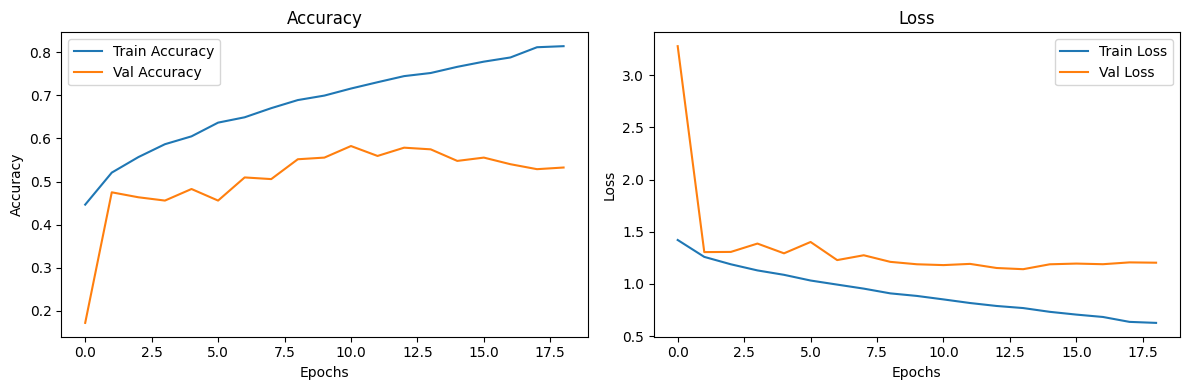

In [12]:
# Plot accuracy and loss charts
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
    
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
plt.tight_layout()
plt.show()

70/70 [==============================] - 2s 25ms/step



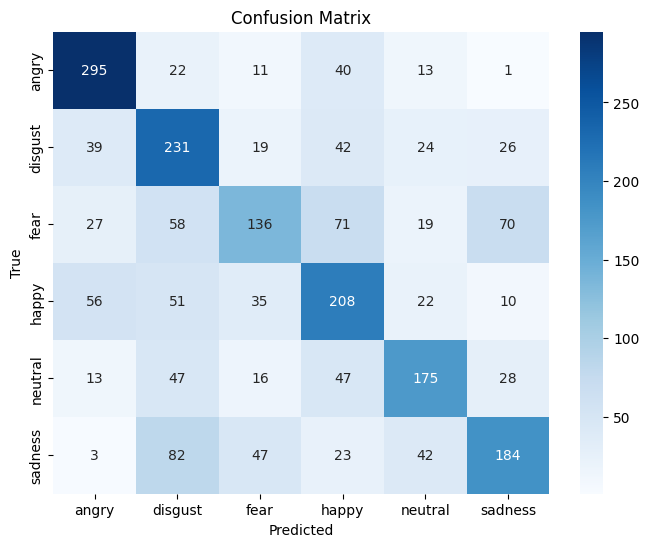


Test Accuracy: 55.0381%
F1-score: 0.5457

Classification Report:
               precision    recall  f1-score   support

       angry       0.68      0.77      0.72       382
     disgust       0.47      0.61      0.53       381
        fear       0.52      0.36      0.42       381
       happy       0.48      0.54      0.51       382
     neutral       0.59      0.54      0.56       326
     sadness       0.58      0.48      0.53       381

    accuracy                           0.55      2233
   macro avg       0.55      0.55      0.55      2233
weighted avg       0.55      0.55      0.55      2233


Most confusing classes (class - rate):

1- fear - 0.6430446194225722
2- sadness - 0.5170603674540682
3- neutral - 0.46319018404907975
4- happy - 0.45549738219895286
5- disgust - 0.3937007874015748
6- angry - 0.22774869109947643


In [13]:
evaluate(model,X_test,y_test,lb)

In [14]:
model.save('model_fspc1.h5')

## Feature Space 2

### Input preparation

In [8]:
X_train2 = fspc_2_train
y_train2 = fspc_2_trainlb

# Labels encoded like this as categorial crossentropy expect the input to be one hot encoded
lb2 = LabelEncoder().fit(y_train2)
y_train2 = np_utils.to_categorical(lb2.transform(y_train2))

X_test2 = fspc_2_test
y_test2 = np_utils.to_categorical(lb2.transform(fspc_2_testlb))

X_val2 = fspc_2_val
y_val2 = np_utils.to_categorical(lb2.transform(fspc_2_vallb))


### Build the CNN Architecture

In [9]:
EPOCHS = 30
batch_size = 32

In [19]:
model2 = load_model('/kaggle/input/model-2/model_fspc2.h5')

In [13]:
model2 = keras.Sequential()

# Convolutional layers
model2.add(keras.layers.Conv2D(75, (5, 5), activation='relu', input_shape=(X_train2.shape[1], X_train2.shape[2], X_train2.shape[3])))
model2.add(keras.layers.MaxPooling2D())

model2.add(keras.layers.Conv2D(135, (5, 5), activation='relu'))
model2.add(keras.layers.MaxPooling2D())

model2.add(keras.layers.Dropout(0.25))

model2.add(keras.layers.Conv2D(75, (5, 5), activation='relu'))
model2.add(keras.layers.MaxPooling2D())

model2.add(keras.layers.Dropout(0.25))

# Flatten layer
model2.add(keras.layers.Flatten())

# Dense layers
model2.add(keras.layers.Dense(45, activation='relu'))
model2.add(keras.layers.Dropout(0.5))

model2.add(keras.layers.Dense(6, activation='softmax'))

# Compile the model
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 124, 75)      1950      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 62, 75)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 59, 58, 135)       253260    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 29, 135)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 29, 29, 135)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 75)       

In [15]:
# Define the callbacks
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, monitor='val_loss')

# Train the model
warnings.filterwarnings("ignore")
history = model2.fit(X_train2, y_train2, epochs=EPOCHS, batch_size=batch_size,
                    validation_data=(X_val2, y_val2), callbacks=[early_stopping, reduce_lr])


Epoch 1/30
619/619 [==============================] - 35s 56ms/step - loss: 1.6385 - accuracy: 0.3005 - val_loss: 1.5169 - val_accuracy: 0.4406 - lr: 1.0000e-04
Epoch 2/30
619/619 [==============================] - 34s 55ms/step - loss: 1.5191 - accuracy: 0.3796 - val_loss: 1.4237 - val_accuracy: 0.4598 - lr: 1.0000e-04
Epoch 3/30
619/619 [==============================] - 34s 55ms/step - loss: 1.4474 - accuracy: 0.4186 - val_loss: 1.3343 - val_accuracy: 0.5287 - lr: 1.0000e-04
Epoch 4/30
619/619 [==============================] - 34s 55ms/step - loss: 1.3659 - accuracy: 0.4606 - val_loss: 1.2962 - val_accuracy: 0.5326 - lr: 1.0000e-04
Epoch 5/30
619/619 [==============================] - 34s 55ms/step - loss: 1.3154 - accuracy: 0.4834 - val_loss: 1.2725 - val_accuracy: 0.5211 - lr: 1.0000e-04
Epoch 6/30
619/619 [==============================] - 34s 55ms/step - loss: 1.2657 - accuracy: 0.5001 - val_loss: 1.2135 - val_accuracy: 0.5632 - lr: 1.0000e-04
Epoch 7/30
619/619 [==============

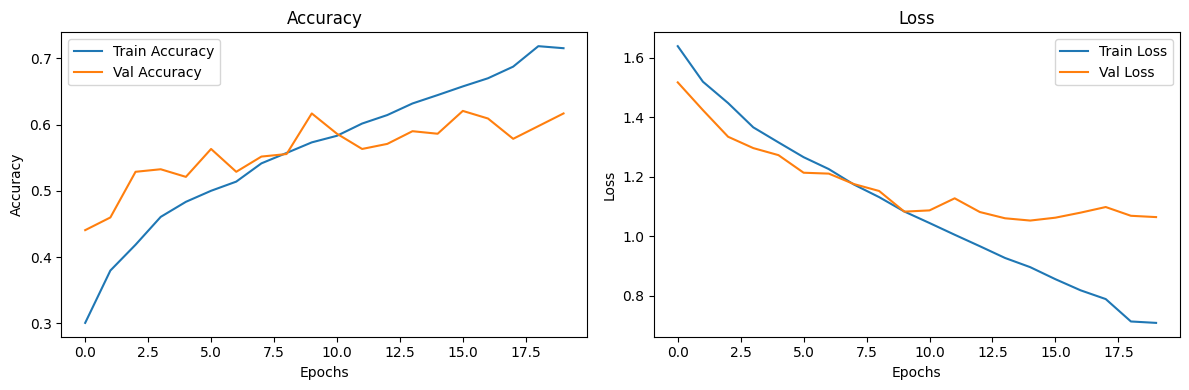

In [17]:
# Plot accuracy and loss charts
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
    
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
plt.tight_layout()
plt.show()

70/70 [==============================] - 1s 11ms/step



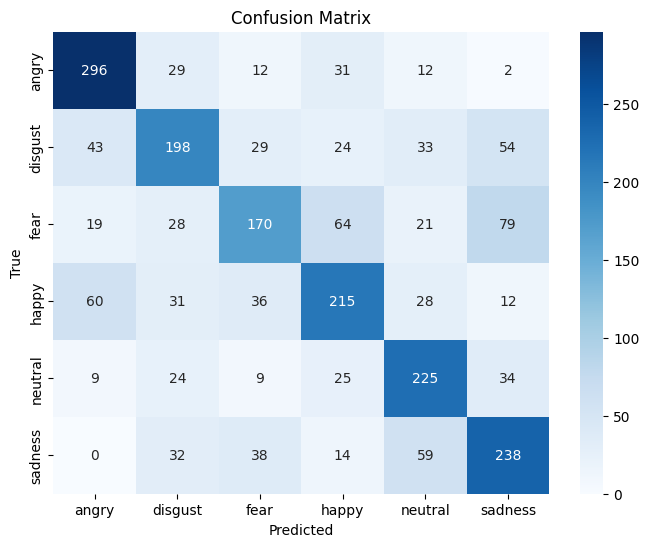


Test Accuracy: 60.0985%
F1-score: 0.5968

Classification Report:
               precision    recall  f1-score   support

       angry       0.69      0.77      0.73       382
     disgust       0.58      0.52      0.55       381
        fear       0.58      0.45      0.50       381
       happy       0.58      0.56      0.57       382
     neutral       0.60      0.69      0.64       326
     sadness       0.57      0.62      0.59       381

    accuracy                           0.60      2233
   macro avg       0.60      0.60      0.60      2233
weighted avg       0.60      0.60      0.60      2233


Most confusing classes (class - rate):

1- fear - 0.5538057742782152
2- disgust - 0.48031496062992124
3- happy - 0.43717277486910994
4- sadness - 0.3753280839895013
5- neutral - 0.3098159509202454
6- angry - 0.225130890052356


In [20]:
evaluate(model2,X_test2,y_test2,lb2)

In [29]:
model2.save('model_fspc2.h5')